In [1]:
# mv this notebook in src folder
# or
# set sys path to src folder
import os, sys
path_to_scr_folder=os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(path_to_scr_folder)

In [11]:
import peak_simulation
import read_chroma
import plot
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4 as nc

In [3]:
# FILENAME of the chromatogram used as model to create the new chromatogram
model_filename='/home/emelda/PFEE/test_gcgc/G0-1-300123.cdf'
model_filename=...
model_filename='/home/emelda/PFEE/test_gcgc/G0-1-300123.cdf'

# PATH where the cdf and the associated ground truth will be created
new_cdf_path=...
new_cdf_path="/home/emelda/PFEE/Python-2DGC/SIMULATION/"
# NAME of the new chromatogram
cdf_name="test"
cdf_name=...
cdf_name="test"

# FILENAME of the HMDB library. The file alread exists in the src folder but can be recreated. See README.md https://github.com/Easy47/Python-2DGC#if-you-need-to-simulate-data (2.)
lib_path='/home/emelda/PFEE/Python-2DGC-main/src/lib_EIB_gt.mgf'
lib_path=...
lib_path='/home/emelda/PFEE/Python-2DGC-main/src/lib_EIB_gt.mgf'

# FILENAME of the HMDB library spectra pairwise scores
scores_path='lib_scores.json'
scores_path=...
scores_path='lib_scores.json'


In [4]:
# params=peak_simulation.simulation_from_cdf_model(new_cdf_path=new_cdf_path, cdf_name=cdf_name, model_filename=model_filename, lib_path=lib_path, scores_path=scores_path, noise_loc=1000.0, noise_scale=500.0, min_overlap=0.70, max_overlap=0.99, intensity_range_min=60000000, intensity_range_max=90000000)

Plot the created chromatogram

In [5]:
# chromato_obj_new=read_chroma.read_chroma(new_cdf_path + '/' + cdf_name + ".cdf")

FileNotFoundError: [Errno 2] No such file or directory: '/home/emelda/PFEE/Python-2DGC/SIMULATION//test.cdf'

In [ ]:
plot.visualizer((chromato_obj_new[0], chromato_obj_new[1]))

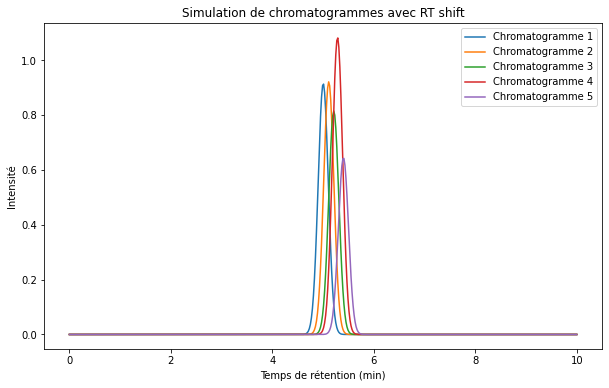

In [6]:
def simulate_multiple_chromatograms(num_chromatograms, base_rt=5.0, rt_variation=0.1, rt_random_shift=0.02, intensity_variation=0.2):
    """
    Simule plusieurs chromatogrammes avec un RT shift réaliste.

    Parameters:
    - num_chromatograms (int): Nombre de chromatogrammes à générer.
    - base_rt (float): Temps de rétention de base pour tous les chromatogrammes.
    - rt_variation (float): Décalage de RT systématique entre chaque chromatogramme.
    - rt_random_shift (float): Déviation aléatoire appliquée à chaque RT pour simuler une variation réaliste.
    - intensity_variation (float): Variation de l'intensité pour simuler des pics de hauteurs différentes.
    
    Returns:
    - chromatograms (list): Liste des données de chromatogrammes simulés.
    """
    chromatograms = []
    
    for i in range(num_chromatograms):
        # Calcule le RT pour ce chromatogramme en ajoutant un décalage systématique et aléatoire
        rt_shift = base_rt + (i * rt_variation) + np.random.normal(0, rt_random_shift)
        
        # Simule un chromatogramme avec le RT ajusté
        retention_times = np.linspace(0, 10, 500)
        
        # Variation d'intensité pour chaque pic
        peak_intensity = 1 + np.random.normal(0, intensity_variation)
        peak_position = peak_intensity * np.exp(-((retention_times - rt_shift)**2) / (2 * (0.1)**2))  # Gaussienne centrée sur le RT
        
        chromatograms.append((retention_times, peak_position))
    
    return chromatograms

# Exemple d'utilisation pour générer et afficher les chromatogrammes
chromatograms = simulate_multiple_chromatograms(num_chromatograms=5, base_rt=5.0)

plt.figure(figsize=(10, 6))
for i, (retention_times, peak_position) in enumerate(chromatograms):
    plt.plot(retention_times, peak_position, label=f'Chromatogramme {i+1}')

plt.xlabel('Temps de rétention (min)')
plt.ylabel('Intensité')
plt.title('Simulation de chromatogrammes avec RT shift')
plt.legend()
plt.show()

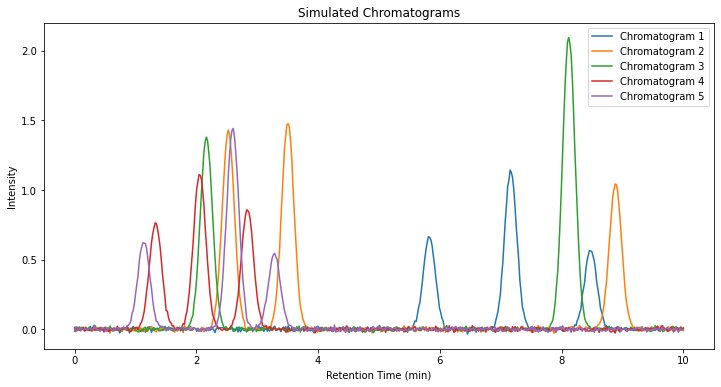

In [7]:
def simulate_chromatograms(num_chromatograms, 
                                   num_peaks=3, 
                                   rt_range=(1, 9), 
                                   intensity_range=(0.5, 1.5), 
                                   peak_width=0.1, 
                                   noise_level=0.01):
    """
    Simulates multiple complex chromatograms with multiple peaks and noise.

    Parameters:
    - num_chromatograms (int): Number of chromatograms to generate.
    - num_peaks (int): Number of peaks per chromatogram.
    - rt_range (tuple): Range of retention times for peak centers (min, max).
    - intensity_range (tuple): Range of peak intensities (min, max).
    - peak_width (float): Standard deviation of Gaussian peaks.
    - noise_level (float): Amplitude of random noise to add to the chromatograms.

    Returns:
    - chromatograms (list): List of simulated chromatogram data (retention times, intensities).
    """
    chromatograms = []
    retention_times = np.linspace(0, 10, 500)  # Retention time

    for _ in range(num_chromatograms):
        intensity = np.zeros_like(retention_times)
        
        for _ in range(num_peaks):
            # Randomize peak parameters
            peak_rt = np.random.uniform(*rt_range)  # Random peak position
            peak_intensity = np.random.uniform(*intensity_range)  # Random peak intensity
            # Gaussian peak shape
            intensity += peak_intensity * np.exp(-((retention_times - peak_rt)**2) / (2 * peak_width**2))
        
        # Add random noise
        noise = np.random.normal(0, noise_level, retention_times.shape)
        intensity += noise
        
        chromatograms.append((retention_times, intensity))
    
    return chromatograms

# Example
chromatograms = simulate_chromatograms(num_chromatograms=5, num_peaks=3)

plt.figure(figsize=(12, 6))
for i, (retention_times, intensity) in enumerate(chromatograms):
    plt.plot(retention_times, intensity, label=f'Chromatogram {i+1}')

plt.xlabel('Retention Time (min)')
plt.ylabel('Intensity')
plt.title('Simulated Chromatograms')
plt.legend()
plt.show()

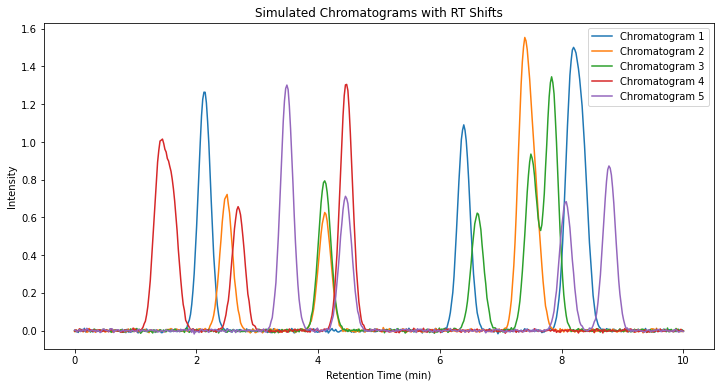

In [12]:
def simulate_chromatograms_with_rt_shift(model_cdf, num_chromatograms, 
                                         num_peaks=3, 
                                         rt_range=(1, 9), 
                                         intensity_range=(0.5, 1.5), 
                                         peak_width=0.1, 
                                         noise_level=0.005, 
                                         systematic_shift=0.1, 
                                         random_shift_std=0.02, 
                                         output_filename="chromatograms.cdf"):
    """
    Simulates chromatograms with RT shifts in two dimensions and saves to CDF format.

    Parameters:
    - num_chromatograms (int): Number of chromatograms to generate.
    - num_peaks (int): Number of peaks per chromatogram.
    - rt_range (tuple): Range of retention times for peak centers (min, max).
    - intensity_range (tuple): Range of peak intensities (min, max).
    - peak_width (float): Standard deviation of Gaussian peaks.
    - noise_level (float): Amplitude of random noise to add to the chromatograms.
    - systematic_shift (float): Systematic retention time shift between chromatograms.
    - random_shift_std (float): Standard deviation of random RT shift for each peak.
    - output_filename (str): Name of the output CDF file.
    
    Returns:
    - chromatograms (list): List of simulated chromatogram data (retention times, intensities).
    """
    chromatograms = []
    retention_times = np.linspace(0, 10, 500)  # Retention time from 0 to 10 minutes

    for i in range(num_chromatograms):
        intensity = np.zeros_like(retention_times)
        base_shift = i * systematic_shift  # Systematic shift for this chromatogram
        
        for _ in range(num_peaks):
            # Randomize peak parameters with shifts
            base_rt = np.random.uniform(*rt_range)
            rt_shift = base_rt + base_shift + np.random.normal(0, random_shift_std)
            peak_intensity = np.random.uniform(*intensity_range)
            
            # Gaussian peak
            intensity += peak_intensity * np.exp(-((retention_times - rt_shift)**2) / (2 * peak_width**2))
        
        # Add random noise
        noise = np.random.normal(0, noise_level, retention_times.shape)
        intensity += noise
        
        chromatograms.append((retention_times, intensity))
    
    save_chromatograms_to_cdf(model_cdf, chromatograms, output_filename)

    return chromatograms


def save_chromatograms_to_cdf(model_cdf, chromatograms, output_filename):
    """
    Saves the generated chromatograms to a CDF (NetCDF) file.

    Parameters:
    - chromatograms (list): List of chromatograms to save.
    - output_filename (str): Name of the output CDF file.
    - model_cdf (str): Path to model cdf
    """
    
    if model_filename:
        ds = nc.Dataset(model_filename, "r")
    else:
        ds = None

    with nc.Dataset(output_filename, "w", format="NETCDF4") as new_cdf:
        if ds:
            # Copy metadata from model
            new_cdf.setncatts(ds.__dict__)
            
         # Create dimensions
        num_chromatograms = len(chromatograms)
        num_points = len(chromatograms[0][0])  # Retention time length
        new_cdf.createDimension("chromatogram", num_chromatograms)
        new_cdf.createDimension("time", num_points)

        # Create variables
        times = new_cdf.createVariable("time", "f4", ("time",))
        intensities = new_cdf.createVariable("intensity", "f4", ("chromatogram", "time"))

        # Fill data
        times[:] = chromatograms[0][0]  # Retention times are the same for all
        for i, (_, intensity) in enumerate(chromatograms):
            intensities[i, :] = intensity

        # Add metadata
        new_cdf.title = "Simulated Chromatograms with RT Shifts"
        new_cdf.description = "Simulated chromatograms based on a custom model."
        new_cdf.history = "Generated with a Python simulation script."



# Example
chromatograms = simulate_chromatograms_with_rt_shift(
    model_cdf = model_filename,
    num_chromatograms=5, 
    num_peaks=4,
    output_filename="simulated_chromatograms.cdf"
)

# Plot the generated chromatograms
plt.figure(figsize=(12, 6))
for i, (retention_times, intensity) in enumerate(chromatograms):
    plt.plot(retention_times, intensity, label=f'Chromatogram {i+1}')

plt.xlabel('Retention Time (min)')
plt.ylabel('Intensity')
plt.title('Simulated Chromatograms with RT Shifts')
plt.legend()
plt.show()